In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv

NOTE! Installing ujson may make loading annotations faster.


2023-09-06 11:11:16,951 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - mmdet.version=2.25.0
2023-09-06 11:11:16,952 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - 11.7
2023-09-06 11:11:16,953 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - GCC 9.4


1.12.0a0+8a1a93a True


In [2]:
!pwd

/webapps/piglegsurgery/piglegcv


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Wed Sep  6 11:11:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:42:00.0 Off |                  N/A |
|  0%   42C    P8     9W / 250W |    205MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
torch.__version__

'1.12.0a0+8a1a93a'

In [6]:
Path("/root/.cache/torch/hub/checkpoints/").exists()

False

In [7]:
!ls /root/.cache/torch/hub/checkpoints/

ls: cannot access '/root/.cache/torch/hub/checkpoints/': No such file or directory


In [8]:
a = [4,5]
a.extend([1,2,3])
a

[4, 5, 1, 2, 3]

In [9]:
# pip install mmcv-full

# Run whole video processing

In [9]:
img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob("*/test*.mp4"))
img_pths[0]

PosixPath('../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4')

2023-09-06 11:13:23.362 | DEBUG    | pigleg_cv:do_computer_vision:40 - CV processing started on ../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4, outputdir=./del_test_video_output/
2023-09-06 11:13:23.363 | DEBUG    | pigleg_cv:run_video_processing2:97 - Running video processing...
2023-09-06 11:13:23.364 | DEBUG    | run_qr:main_qr:70 - looking for qr code...
2023-09-06 11:13:23.527 | DEBUG    | run_qr:main_qr:99 - frame=0
2023-09-06 11:13:23.560 | DEBUG    | run_qr:main_qr:99 - frame=10
2023-09-06 11:13:23.592 | DEBUG    | run_qr:main_qr:99 - frame=20
2023-09-06 11:13:23.623 | DEBUG    | run_qr:main_qr:99 - frame=30
2023-09-06 11:13:23.655 | DEBUG    | run_qr:main_qr:99 - frame=40
2023-09-06 11:13:23.687 | DEBUG    | run_qr:main_qr:99 - frame=50


Fusing layers... 
IDetect.fuse


2023-09-06 11:13:23.719 | DEBUG    | run_qr:main_qr:99 - frame=60
2023-09-06 11:13:23.749 | DEBUG    | run_qr:main_qr:99 - frame=70
2023-09-06 11:13:23.779 | DEBUG    | run_qr:main_qr:99 - frame=80
2023-09-06 11:13:23.809 | DEBUG    | run_qr:main_qr:99 - frame=90
2023-09-06 11:13:23.839 | DEBUG    | run_qr:main_qr:99 - frame=100
2023-09-06 11:13:23.868 | DEBUG    | run_qr:main_qr:99 - frame=110
2023-09-06 11:13:23.898 | DEBUG    | run_qr:main_qr:99 - frame=120
2023-09-06 11:13:23.926 | DEBUG    | run_qr:main_qr:99 - frame=130
2023-09-06 11:13:23.954 | DEBUG    | run_qr:main_qr:99 - frame=140
2023-09-06 11:13:23.982 | DEBUG    | run_qr:main_qr:99 - frame=150
2023-09-06 11:13:24.010 | DEBUG    | run_qr:main_qr:99 - frame=160
2023-09-06 11:13:24.038 | DEBUG    | run_qr:main_qr:99 - frame=170
2023-09-06 11:13:24.066 | DEBUG    | run_qr:main_qr:99 - frame=180
2023-09-06 11:13:24.092 | DEBUG    | run_qr:main_qr:125 - prepared to save to file del_test_video_output/meta.json
2023-09-06 11:13:2

prepared to save to file del_test_video_output/meta.json
185
Fusing layers... 
IDetect.fuse


2023-09-06 11:13:24.300 | DEBUG    | run_perpendicular:main_perpendicular:267 - main_perpendicular...
2023-09-06 11:13:24.365 | DEBUG    | run_perpendicular:main_perpendicular:275 - incision detection ...
2023-09-06 11:13:24,366 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - checkpoint_path.exists=True
2023-09-06 11:13:24,367 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - img.shape=(540, 960, 3), max(img)=255


185
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2023-09-06 11:13:25,128 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 1
2023-09-06 11:13:25.129 | DEBUG    | tools:save_json:9 - Writing 'del_test_video_output/meta.json'
2023-09-06 11:13:25.130 | DEBUG    | tools:save_json:18 - old keys: ['qr_data', 'pixelsize_m_by_incision_size', 'incision_bboxes']
2023-09-06 11:13:25.130 | DEBUG    | tools:save_json:20 - updated keys: ['qr_data', 'pixelsize_m_by_incision_size', 'incision_bboxes']
2023-09-06 11:13:25.132 | DEBUG    | run_perpendicular:main_perpendicular:277 - len(imgs)=1
2023-09-06 11:13:25.152 | DEBUG    | tools:save_json:9 - Writing './del_test_video_output/perpendicular.json'
2023-09-06 11:13:25.153 | DEBUG    | tools:save_j

device=cuda


2023-09-06 11:13:26,655 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-06 11:13:26,680 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-06 11:13:26,680 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-06 11:13:26,681 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
Downloading: "https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth" to /root/.cache/torch/hub/checkpoints/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pt

  0%|          | 0.00/379M [00:00<?, ?B/s]

2023-09-06 11:13:45,181 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 320, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 320, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 320, 1, 1]).
size m

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2023-09-06 11:14:10.234 | DEBUG    | pigleg_cv:run_video_processing2:117 - Tracker finished in 44.919244050979614s.
2023-09-06 11:14:10.235 | DEBUG    | pigleg_cv:run_video_processing2:124 - filename=../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4, outputdir=./del_test_video_output/
2023-09-06 11:14:10.236 | DEBUG    | pigleg_cv:run_video_processing2:125 - filename=True, outputdir=True
2023-09-06 11:14:10.242 | DEBUG    | run_report:main_report:669 - size_input_video: [960, 540], size_output_video: [1301, 420], size_output_img: [746, 420], resize_factor: 0.7777777777777778
2023-09-06 11:14:10.244 | DEBUG    | run_report:main_report:688 - Sort data N=
/webapps/piglegsurgery/piglegcv/run_report.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you mus

11705.022043198347
b Needle holder
g Scissors


2023-09-06 11:14:11.355 | DEBUG    | run_report:main_report:752 - Frame 10 processed!
2023-09-06 11:14:12.326 | DEBUG    | run_report:main_report:752 - Frame 20 processed!
2023-09-06 11:14:13.286 | DEBUG    | run_report:main_report:752 - Frame 30 processed!
2023-09-06 11:14:14.261 | DEBUG    | run_report:main_report:752 - Frame 40 processed!
2023-09-06 11:14:15.231 | DEBUG    | run_report:main_report:752 - Frame 50 processed!
2023-09-06 11:14:16.206 | DEBUG    | run_report:main_report:752 - Frame 60 processed!
2023-09-06 11:14:17.198 | DEBUG    | run_report:main_report:752 - Frame 70 processed!
2023-09-06 11:14:18.178 | DEBUG    | run_report:main_report:752 - Frame 80 processed!
2023-09-06 11:14:19.155 | DEBUG    | run_report:main_report:752 - Frame 90 processed!
2023-09-06 11:14:20.123 | DEBUG    | run_report:main_report:752 - Frame 100 processed!
2023-09-06 11:14:21.094 | DEBUG    | run_report:main_report:752 - Frame 110 processed!
2023-09-06 11:14:22.062 | DEBUG    | run_report:main

bbox
[283.20086669921875, 227.19700622558594, 493.01824951171875, 437.01438903808594, 0.9942836165428162]


2023-09-06 11:14:30.347 | DEBUG    | run_report:create_pdf_report:333 - main_report: No data to report
2023-09-06 11:14:30.358 | DEBUG    | run_report:create_heatmap_report_plt:164 - points.shape=(0,)
2023-09-06 11:14:30.359 | WARNING  | run_report:create_heatmap_report_plt:167 - No points found for heatmap
2023-09-06 11:14:30.588 | DEBUG    | run_report:create_pdf_report:294 - main_report: figures ./del_test_video_output/graph_2c_trajectory.jpg is saved
2023-09-06 11:14:30.755 | DEBUG    | run_report:create_pdf_report:323 - main_report: figures ./del_test_video_output/fig_2a_scissors_graph.jpg is saved
2023-09-06 11:14:30.765 | DEBUG    | run_report:create_heatmap_report_plt:164 - points.shape=(120, 2)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2023-09-06 11:14:31.014 | DEBUG    | run_report:create_pdf_report:333 - main_report: No data to report
2023-09-06 11:14:31

main_report: Video file ../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4 is processed!


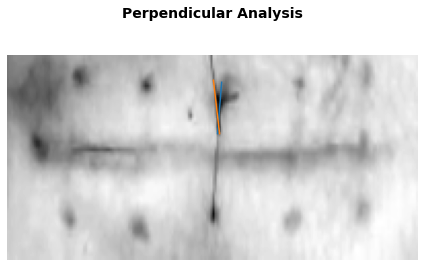

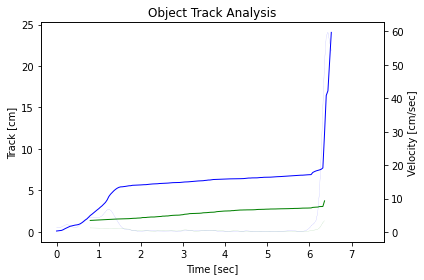

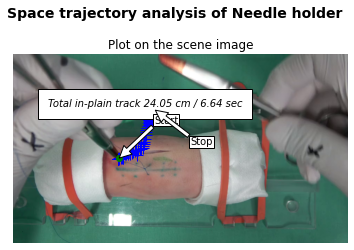

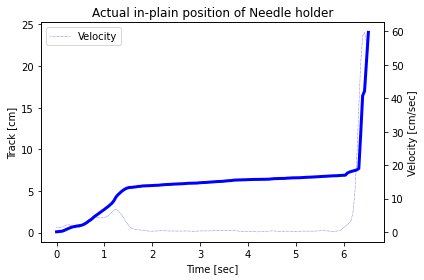

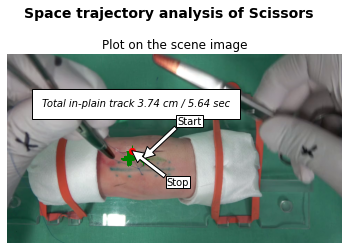

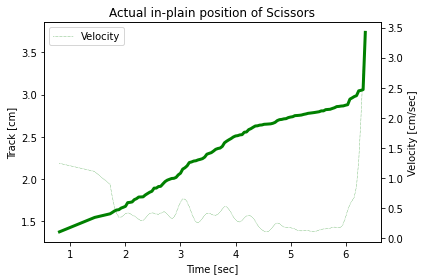

In [12]:
outputdir = "./del_test_video_output/"
pigleg_cv.do_computer_vision(img_pths[0], outputdir , meta=None)

2023-09-06 11:14:31.802 | DEBUG    | run_report:main_report:669 - size_input_video: [960, 540], size_output_video: [1301, 420], size_output_img: [746, 420], resize_factor: 0.7777777777777778
2023-09-06 11:14:31.804 | DEBUG    | run_report:main_report:688 - Sort data N=
/webapps/piglegsurgery/piglegcv/run_report.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frame_ids_list = np.asarray(frame_ids).tolist()
2023-09-06 11:14:31.813 | DEBUG    | tools:save_json:9 - Writing './del_test_video_output//tracks_points.json'
2023-09-06 11:14:31.813 | DEBUG    | tools:save_json:20 - updated keys: ['frame_ids', 'data_pixels_0', 'data_pixels_1', 'data_pixels_2', 'data_pixels_3']
2023-09-06 11:14:31.877 | DEBUG    | run_report:create_video_report_figure:539 - main_video_report

11705.022043198347
b Needle holder
g Scissors


2023-09-06 11:14:32.881 | DEBUG    | run_report:main_report:752 - Frame 10 processed!
2023-09-06 11:14:33.825 | DEBUG    | run_report:main_report:752 - Frame 20 processed!
2023-09-06 11:14:34.772 | DEBUG    | run_report:main_report:752 - Frame 30 processed!
2023-09-06 11:14:35.711 | DEBUG    | run_report:main_report:752 - Frame 40 processed!
2023-09-06 11:14:36.652 | DEBUG    | run_report:main_report:752 - Frame 50 processed!
2023-09-06 11:14:37.590 | DEBUG    | run_report:main_report:752 - Frame 60 processed!
2023-09-06 11:14:38.527 | DEBUG    | run_report:main_report:752 - Frame 70 processed!
2023-09-06 11:14:39.463 | DEBUG    | run_report:main_report:752 - Frame 80 processed!
2023-09-06 11:14:40.396 | DEBUG    | run_report:main_report:752 - Frame 90 processed!
2023-09-06 11:14:41.342 | DEBUG    | run_report:main_report:752 - Frame 100 processed!
2023-09-06 11:14:42.279 | DEBUG    | run_report:main_report:752 - Frame 110 processed!
2023-09-06 11:14:43.215 | DEBUG    | run_report:main

bbox
[283.20086669921875, 227.19700622558594, 493.01824951171875, 437.01438903808594, 0.9942836165428162]


2023-09-06 11:14:51.125 | DEBUG    | run_report:create_pdf_report:333 - main_report: No data to report
2023-09-06 11:14:51.132 | DEBUG    | run_report:create_heatmap_report_plt:164 - points.shape=(0,)
2023-09-06 11:14:51.133 | WARNING  | run_report:create_heatmap_report_plt:167 - No points found for heatmap
2023-09-06 11:14:51.355 | DEBUG    | run_report:create_pdf_report:294 - main_report: figures ./del_test_video_output/graph_2c_trajectory.jpg is saved
2023-09-06 11:14:51.524 | DEBUG    | run_report:create_pdf_report:323 - main_report: figures ./del_test_video_output/fig_2a_scissors_graph.jpg is saved
2023-09-06 11:14:51.533 | DEBUG    | run_report:create_heatmap_report_plt:164 - points.shape=(120, 2)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2023-09-06 11:14:51.777 | DEBUG    | run_report:create_pdf_report:333 - main_report: No data to report
2023-09-06 11:14:51

main_report: Video file ../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4 is processed!


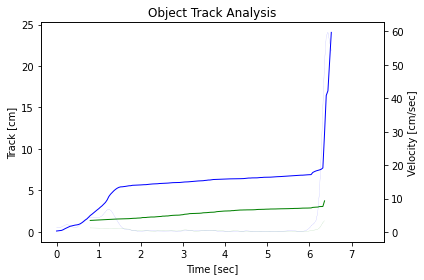

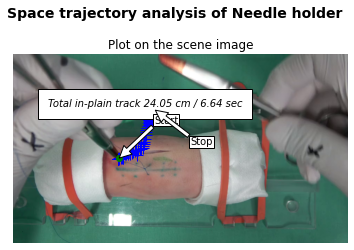

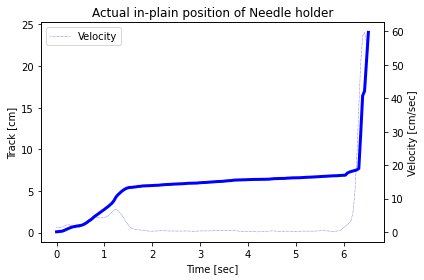

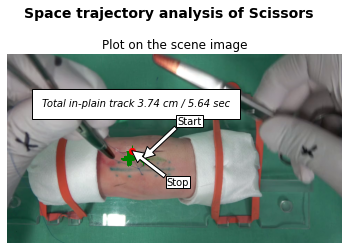

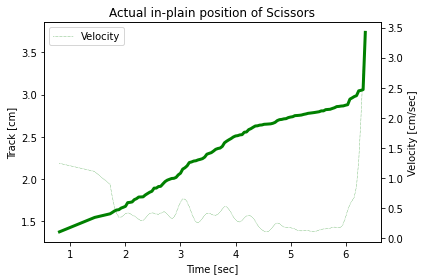

In [13]:

# pigleg_cv.do_computer_vision(img_pths[0],  "./del_test_video_output/", meta=None)
pigleg_cv.main_report(str(img_pths[0]),  outputdir)

In [13]:
import os.path
import json
import pandas as pd
from tools import flatten_dict, remove_empty_lists

novy = {
}

filename = Path(outputdir) / "meta.json"
if os.path.isfile(filename):
    with open(filename, 'r') as fr:
        data = json.load(fr)
        novy.update(data)

# filename = Path(serverfile.outputdir) / "evaluation.json"
filename = Path(outputdir) / "results.json"
if os.path.isfile(filename):
    with open(filename, 'r') as fr:
        data = json.load(fr)
        novy.update(data)

In [14]:
print(novy)


{'qr_data': {'pix_size_method': 'video size estimation', 'is_detected': False, 'box': [], 'pix_size': 1.0, 'qr_size': 0.027, 'size_by_scene': 0.0003125, 'text': None, 'qr_scissors_frames': []}, 'pixelsize_m_by_incision_size': 0.0003333333333333334, 'incision_bboxes': [[283.20086669921875, 304.21234130859375, 493.01824951171875, 359.9990539550781, 0.9942836165428162]], 'Needle holder length [m]': 0.24053719983441682, 'Needle holder visibility [s]': 6.640000000000001, 'Needle holder velocity': 0.03312547836389318, 'Needle holder unit': 'm', 'Needle holder visibility [%]': 89.72972972972973, 'Needle holder zone presence [%]': 21.21212121212121, 'Scissors length [m]': 0.03736967463743802, 'Scissors visibility [s]': 5.640000000000001, 'Scissors velocity': 0.004123953506962486, 'Scissors unit': 'm', 'Scissors visibility [%]': 76.21621621621621, 'Scissors zone presence [%]': 100.0}


In [15]:
print(flatten_dict(novy))

{'qr_data_pix_size_method': 'video size estimation', 'qr_data_is_detected': False, 'qr_data_box': [], 'qr_data_pix_size': 1.0, 'qr_data_qr_size': 0.027, 'qr_data_size_by_scene': 0.0003125, 'qr_data_text': None, 'qr_data_qr_scissors_frames': [], 'pixelsize_m_by_incision_size': 0.0003333333333333334, 'incision_bboxes': [[283.20086669921875, 304.21234130859375, 493.01824951171875, 359.9990539550781, 0.9942836165428162]], 'Needle holder length [m]': 0.24053719983441682, 'Needle holder visibility [s]': 6.640000000000001, 'Needle holder velocity': 0.03312547836389318, 'Needle holder unit': 'm', 'Needle holder visibility [%]': 89.72972972972973, 'Needle holder zone presence [%]': 21.21212121212121, 'Scissors length [m]': 0.03736967463743802, 'Scissors visibility [s]': 5.640000000000001, 'Scissors velocity': 0.004123953506962486, 'Scissors unit': 'm', 'Scissors visibility [%]': 76.21621621621621, 'Scissors zone presence [%]': 100.0}


In [16]:
nnovy = remove_empty_lists(flatten_dict(novy))
print(nnovy)

{'qr_data_pix_size_method': 'video size estimation', 'qr_data_is_detected': False, 'qr_data_pix_size': 1.0, 'qr_data_qr_size': 0.027, 'qr_data_size_by_scene': 0.0003125, 'qr_data_text': None, 'pixelsize_m_by_incision_size': 0.0003333333333333334, 'incision_bboxes': [[283.20086669921875, 304.21234130859375, 493.01824951171875, 359.9990539550781, 0.9942836165428162]], 'Needle holder length [m]': 0.24053719983441682, 'Needle holder visibility [s]': 6.640000000000001, 'Needle holder velocity': 0.03312547836389318, 'Needle holder unit': 'm', 'Needle holder visibility [%]': 89.72972972972973, 'Needle holder zone presence [%]': 21.21212121212121, 'Scissors length [m]': 0.03736967463743802, 'Scissors visibility [s]': 5.640000000000001, 'Scissors velocity': 0.004123953506962486, 'Scissors unit': 'm', 'Scissors visibility [%]': 76.21621621621621, 'Scissors zone presence [%]': 100.0}


In [17]:
df_novy = pd.DataFrame(nnovy, index=[0])
df_novy

,qr_data_pix_size_method,qr_data_is_detected,qr_data_pix_size,qr_data_qr_size,qr_data_size_by_scene,qr_data_text,pixelsize_m_by_incision_size,incision_bboxes,Needle holder length [m],Needle holder visibility [s],Needle holder velocity,Needle holder unit,Needle holder visibility [%],Needle holder zone presence [%],Scissors length [m],Scissors visibility [s],Scissors velocity,Scissors unit,Scissors visibility [%],Scissors zone presence [%]
0,video size estimation,False,1.0,0.027,0.000313,None,0.000333,"[283.20086669921875, 304.21234130859375, 493.0...",0.240537,6.64,0.033125,m,89.72973,21.212121,0.03737,5.64,0.004124,m,76.216216,100.0


In [18]:
img_pths[0]

PosixPath('../piglegsurgeryweb/media/upload/20221009-162416_test_video_end_f84edcc4ca3c01ea693603cd120ac74bc69b93d8/test_video_end.mp4')

In [19]:
!python /home/appuser/mmdetection/mmdet/utils/collect_env.py

fatal: detected dubious ownership in repository at '/webapps/piglegsurgery'
To add an exception for this directory, call:

	git config --global --add safe.directory /webapps/piglegsurgery
sys.platform: linux
Python: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) [GCC 10.3.0]
CUDA available: True
GPU 0: NVIDIA GeForce GTX 1080 Ti
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 11.7, V11.7.64
GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
PyTorch: 1.12.0a0+8a1a93a
PyTorch compiling details: PyTorch built with:
  - GCC 9.4
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash N/A)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_52,code=sm_52;-gencode;arch=compute_60,cod

In [33]:
!pwd

/webapps/piglegsurgery/piglegcv


In [34]:
pip list

Package                       Version                  Editable project location
----------------------------- ------------------------ -------------------------
absl-py                       1.0.0
addict                        2.4.0
alabaster                     0.7.12
albumentations                1.3.1
apex                          0.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
async-timeout                 4.0.2
asynctest                     0.13.0
attributee                    0.1.5
attrs                         21.4.0
audioread                     2.1.9
Babel                         2.10.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
bleach                        5.0.0
blis                          0.7.7
brotlipy                      0.7.0
cachetools                    5.0.0
catalogue                     2.0.6
certi

In [35]:
# !MMCV_WITH_OPS=1 FORCE_CUDA=1 pip install mmcv-full==1.5.2

In [36]:
# !pip uninstall -y mmcv-full